In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
filepath = 'data/train.csv'
df = pd.read_csv(filepath)


In [101]:
data = df.copy()

In [102]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Exploratory Data Analysis

In [103]:
# size of dataset
data.shape

(8693, 14)

In [104]:
# information about features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [105]:
# categorical variables
categorical_features = [col for col in data.select_dtypes(include=['object']).columns]
print (categorical_features)

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


In [106]:
# numerical variables
numerical_features = [col for col in data.select_dtypes(include=['number']).columns]
print (numerical_features)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [107]:
# number of duplicated rows
data.duplicated().sum()

0

In [108]:
# percentage of missing data per column
data.isna().mean()*100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

Most columns have ~2% of missing values. There are multiple strategies of dealing with missing data, the most simple being to drop those observations:

In [109]:
# percentage of data loss by dropping observations with missing data
data_loss = 1 - (data.dropna().shape[0]/data.shape[0])
print (f"By dropping rows with missing data we lose {round(data_loss,2)*100}% of the original dataset size")

By dropping rows with missing data we lose 24.0% of the original dataset size


Dropping observations with missing information leads to a considerable loss in the size of the dataset, so I'll try to see if I can fill in the missing data for some of these features

In [110]:
# describe data (numerical variables)
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [111]:
# describe data (categorical variables)
data.describe(include=[object])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


#### PassangerId
A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

In [112]:
data['PassengerId'].nunique()

8693

Since the PassengerId column contains information about the group each individual passenger is travelling with, I'll extract that information to have an idea of how many groups are in the dataset

In [113]:
data['Group']=data['PassengerId'].str.split('_').str[0]
print (f"There are {data['Group'].nunique()} groups of passengers in the dataset")

There are 6217 groups of passengers in the dataset


In [114]:
# distribuition of groups by number of passengers
pd.cut(data['Group'].value_counts(dropna=False),bins=5).value_counts()

count
(0.993, 2.4]    5646
(2.4, 3.8]       340
(3.8, 5.2]       156
(6.6, 8.0]        46
(5.2, 6.6]        29
Name: count, dtype: int64

In [115]:
#data['Group'].value_counts().hist(grid=False)

#### HomePlanet

In [116]:
data['HomePlanet'].value_counts(dropna=False)

HomePlanet
Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: count, dtype: int64

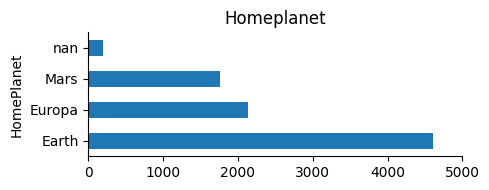

In [117]:
plt.figure(figsize=(5,2))
plt.title('Homeplanet')
data['HomePlanet'].value_counts(dropna=False).plot.barh()

plt.xlim(0,5000)

sns.despine()
plt.tight_layout()

Are there differences in the % of Transported passengers based on their Homeplanet?

In [118]:
data.groupby(by=['HomePlanet'],dropna=False).Transported.value_counts(dropna=False, normalize=True)*100

HomePlanet  Transported
Earth       False          57.605389
            True           42.394611
Europa      True           65.884561
            False          34.115439
Mars        True           52.302445
            False          47.697555
NaN         True           51.243781
            False          48.756219
Name: proportion, dtype: float64

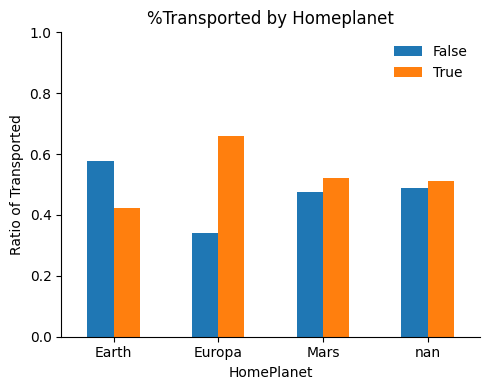

In [119]:
data.groupby(by=['HomePlanet'],dropna=False).Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Transported by Homeplanet')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

Interestingly it seems that passengers from Europa are more likely to be Transported than not

#### CryoSleep

In [120]:
data.CryoSleep.value_counts(dropna=False)

CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64

In [121]:
data.groupby(by=['CryoSleep'],dropna=False).Transported.value_counts(dropna=False, normalize=True)*100

CryoSleep  Transported
False      False          67.107924
           True           32.892076
True       True           81.758314
           False          18.241686
NaN        False          51.152074
           True           48.847926
Name: proportion, dtype: float64

Since the CryoSleep feature relates to whether or not passengers had elected to be put to sleep during the entire duration of the voyage, I expected that passengers these passengers were less likely to be rescued (since they were confined to their cabins). 

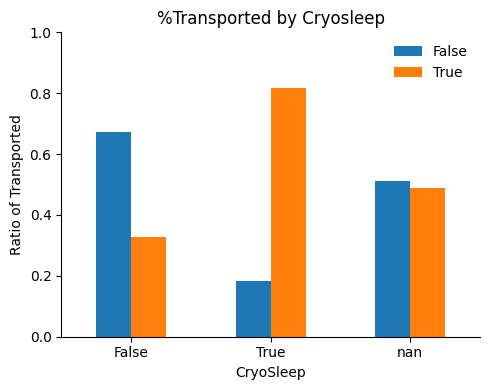

In [122]:
data.groupby(by=['CryoSleep'],dropna=False).Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Transported by Cryosleep')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

In fact, the opposite seems to be true, as passengers who were not put in Cryosleep are least likely to be rescued, whereas passengers in Cryosleep are much more likely to be rescued.

Since being put in Cryosleep is probably expensive, I investigated whether VIP passengers were more likely to be in suspended animation during the voyage

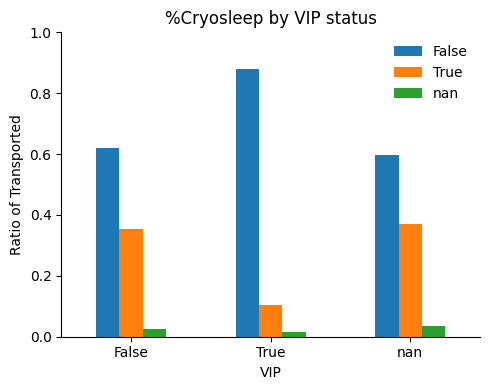

In [149]:
data.groupby(by=['VIP'],dropna=False).CryoSleep.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Cryosleep by VIP status')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

Once again, the opposite seems to be True since as VIP passengers are less likely to not be put in Cryosleep.

#### Cabin

The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [124]:
data.Cabin.value_counts(dropna=False)

Cabin
NaN        199
G/734/S      8
C/137/S      7
B/201/P      7
G/109/P      7
          ... 
G/556/P      1
E/231/S      1
G/545/S      1
G/543/S      1
C/178/S      1
Name: count, Length: 6561, dtype: int64

In [125]:
print (f"The spaceship has {data.Cabin.nunique()} unique cabins")

The spaceship has 6560 unique cabins


Since the "Cabin" feature has information about deck, number and side of the cabin where each passenger is statying, I'll be creating 3 distinct features based on "Cabin" to see if we can indetify any interesting patterns.

In [126]:
# Create Deck, Number and Side features from Cabin
data[['Deck', 'Number', 'Side']] = data['Cabin'].str.split('/', expand=True)

In [127]:
# check that transformation of Cabin feature worked
data[['Cabin','Deck','Number','Side']].head()

,Cabin,Deck,Number,Side
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S
4,F/1/S,F,1,S


In [128]:
data.Deck.value_counts(dropna=False)

Deck
F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
NaN     199
T         5
Name: count, dtype: int64

Most passengers are from Decks "F" and "G". Are the passengers from any particular deck more likely to be transported?

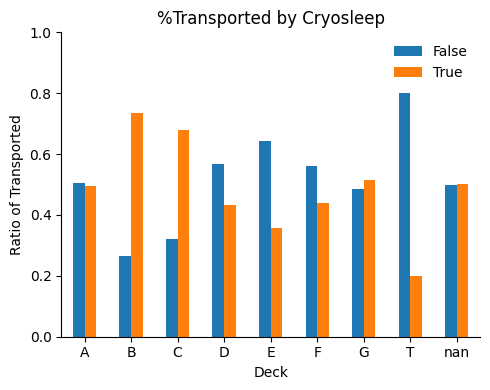

In [129]:
data.groupby(by=['Deck'],dropna=False).Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Transported by Deck')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

The passengers in decks "B" and "C" are more likely to be Transported than passengers in other decks. Passengers in deck "T" (while only being 5), appear less likely to be rescued. 

##### Number

In [130]:
data.Number.nunique()

1817

At a first glance the "Number" of the cabin where the passengers are staying might not be directly related to whether or not it gets transported. However, similar to the "Deck" feature the cabin "Number" might hide some correlations, such as:

1. If the spaceship is split in half, with even cabin numbers on one side and odd numbers on the other, than maybe passengers from one side of the spaceship are more likely to be transported following the collision.

2. If smaller numbers are more common on "one side" of the spaceship (port-side for example), than maybe passengers on one end of the spaceship are more likely to be transported compared to the passengers on the other end of the ship.

In [131]:
# convert "Number" column to numeric
data['Number'] = data['Number'].astype('Int64')

In [140]:
# create Even_Odd column based on whether the cabin number is even or odd
data['Even_Odd'] = data['Number'].apply(lambda x: 'Odd' if x % 2 else 'Even')

In [141]:
data['Even_Odd'].value_counts(dropna=False)

Even_Odd
Odd     4484
Even    4209
Name: count, dtype: int64

In [142]:
data.groupby(by=['Even_Odd'],dropna=False).Transported.value_counts(dropna=False, normalize=True)*100

Even_Odd  Transported
Even      False          50.463293
          True           49.536707
Odd       True           51.137377
          False          48.862623
Name: proportion, dtype: float64

It seems being on an even or odd numbered cabin has no influence on whether the passengers are transported.

#### Side

In [146]:
data['Side'].value_counts(dropna=False)

Side
S      4288
P      4206
NaN     199
Name: count, dtype: int64

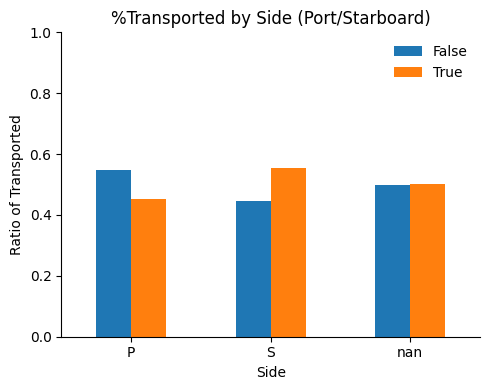

In [148]:
data.groupby(by=['Side'],dropna=False).Transported.value_counts(dropna=False, normalize=True).unstack().plot.bar(rot=0, figsize=(5,4))
plt.title('%Transported by Side (Port/Starboard)')

plt.ylim(0,1)
plt.ylabel('Ratio of Transported')

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()

It seems passengers with cabins on the Starboard-side of the ship are more likely to get transported than those with cabins on the Port-side.

In [132]:
data['Age'].isna().sum()

179

In [133]:
data['Transported'].value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

In [134]:
data[data['Age']==0].Transported.value_counts()

Transported
True     144
False     34
Name: count, dtype: int64

In [135]:
data[numerical_features]

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0
8689,18.0,0.0,0.0,0.0,0.0,0.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0
